# Perceptron Classifier in Machine Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vuhung16au/nlp-learning-journey/blob/main/examples/perceptron.ipynb)

## Overview

The Perceptron is a linear classifier that forms the foundation of neural networks. It's a simple yet powerful algorithm for binary classification tasks. This notebook demonstrates how to use Scikit-Learn's Perceptron implementation and compares it with SGDClassifier configured for perceptron learning.

## What You'll Learn

- Understanding the Perceptron algorithm
- Using Scikit-Learn's Perceptron class
- SGDClassifier with perceptron loss function
- Comparing different perceptron implementations
- Visualizing decision boundaries
- Performance evaluation and metrics

## Prerequisites

Basic understanding of Python, machine learning concepts, and linear classification.

In [1]:
# Environment Detection and Setup
import sys
import subprocess

# Detect the runtime environment
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
IS_LOCAL = not (IS_COLAB or IS_KAGGLE)

print(f"Environment detected:")
print(f"  - Local: {IS_LOCAL}")
print(f"  - Google Colab: {IS_COLAB}")
print(f"  - Kaggle: {IS_KAGGLE}")

# Platform-specific system setup
if IS_COLAB:
    print("\nSetting up Google Colab environment...")
    !apt update -qq
    !apt install -y -qq libpq-dev
elif IS_KAGGLE:
    print("\nSetting up Kaggle environment...")
    # Kaggle usually has most packages pre-installed
else:
    print("\nSetting up local environment...")

# Install required packages for this notebook
required_packages = [
    "scikit-learn",
    "numpy",
    "matplotlib",
    "pandas",
    "seaborn"
]

print("\nInstalling required packages...")
for package in required_packages:
    if IS_COLAB or IS_KAGGLE:
        !pip install -q {package}
    else:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", package],
                      capture_output=True)
    print(f"✓ {package}")

Environment detected:
  - Local: False
  - Google Colab: True
  - Kaggle: False

Setting up Google Colab environment...
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
libpq-dev is already the newest version (14.19-0ubuntu0.22.04.1).
libpq-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.

Installing required packages...
✓ scikit-learn
✓ numpy
✓ matplotlib
✓ pandas
✓ seaborn


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## Perceptron Theory

The Perceptron is a linear binary classifier that learns a separating hyperplane for linearly separable data. The algorithm was invented by Frank Rosenblatt in 1957.

### Key Concepts:

1. **Linear Decision Boundary**: The perceptron finds a linear boundary to separate classes
2. **Iterative Learning**: Updates weights based on misclassified examples
3. **Convergence**: Guaranteed to converge for linearly separable data

### Mathematical Foundation:

For input features $x = [x_1, x_2, ..., x_n]$ and weights $w = [w_1, w_2, ..., w_n]$:

$$f(x) = \text{sign}(w \cdot x + b)$$

Where $b$ is the bias term and $\text{sign}$ is the activation function.

The weight update rule for misclassified examples:
$$w_{new} = w_{old} + \eta \cdot y \cdot x$$

Where $\eta$ is the learning rate and $y$ is the true label.

## Dataset: Iris Flowers

We'll use the famous Iris dataset, which contains measurements of iris flowers from three species. For the Perceptron (binary classifier), we'll focus on distinguishing one species from the others.

In [3]:
# Load the iris dataset
iris = load_iris()
print("Iris Dataset Information:")
print(f"- Features: {iris.feature_names}")
print(f"- Target classes: {iris.target_names}")
print(f"- Dataset shape: {iris.data.shape}")
print(f"- Number of samples per class: {np.bincount(iris.target)}")

# Create a DataFrame for easy exploration
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target_names[iris.target]

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

Iris Dataset Information:
- Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
- Target classes: ['setosa' 'versicolor' 'virginica']
- Dataset shape: (150, 4)
- Number of samples per class: [50 50 50]

First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Dataset statistics:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333  

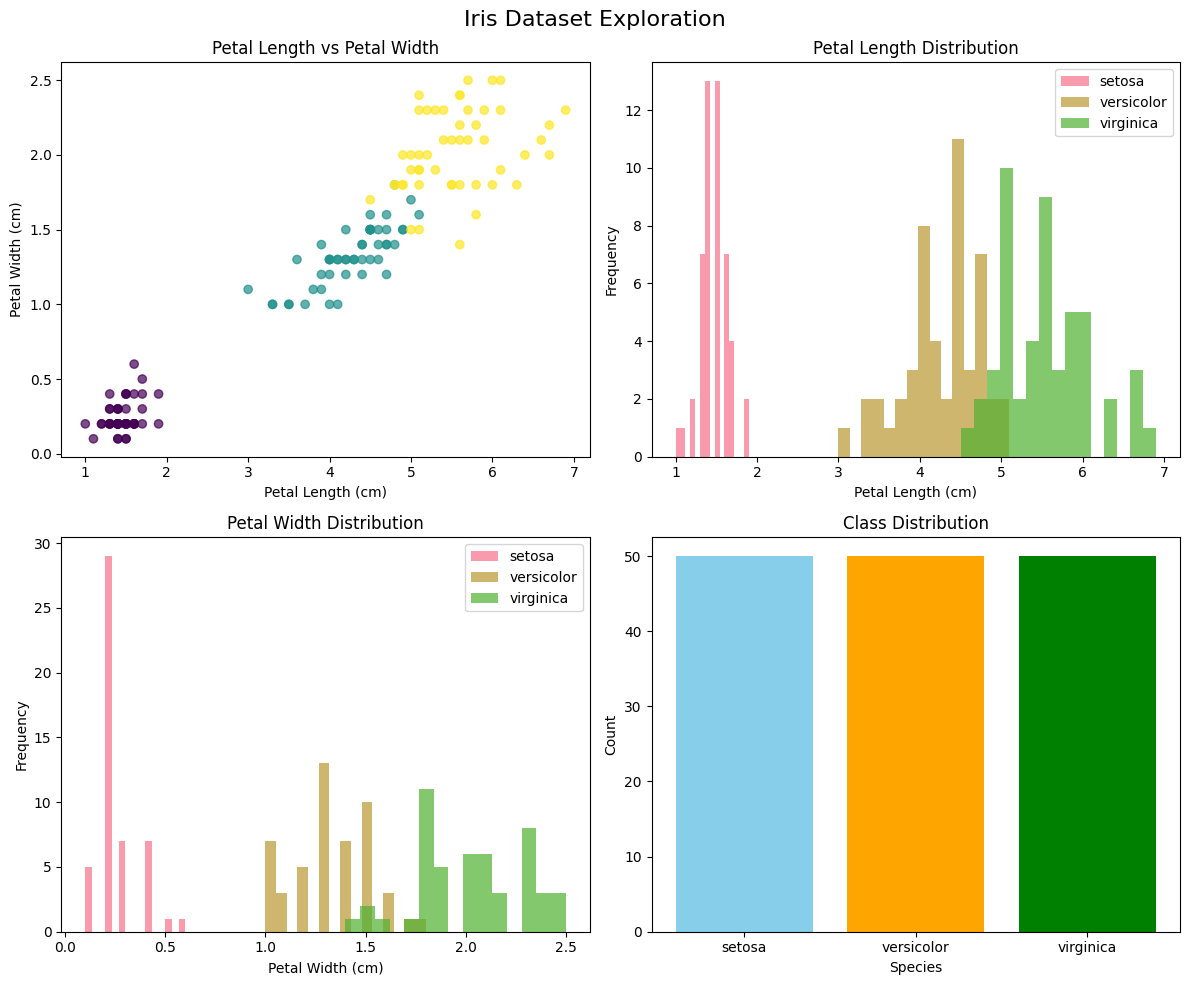

In [4]:
# Visualize the dataset
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Iris Dataset Exploration', fontsize=16)

# Pairplot of the first two features (which we'll use for perceptron)
axes[0, 0].scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target, cmap='viridis', alpha=0.7)
axes[0, 0].set_xlabel('Petal Length (cm)')
axes[0, 0].set_ylabel('Petal Width (cm)')
axes[0, 0].set_title('Petal Length vs Petal Width')

# Distribution of petal length
for i, species in enumerate(iris.target_names):
    species_data = iris.data[iris.target == i, 2]
    axes[0, 1].hist(species_data, alpha=0.7, label=species, bins=15)
axes[0, 1].set_xlabel('Petal Length (cm)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Petal Length Distribution')
axes[0, 1].legend()

# Distribution of petal width
for i, species in enumerate(iris.target_names):
    species_data = iris.data[iris.target == i, 3]
    axes[1, 0].hist(species_data, alpha=0.7, label=species, bins=15)
axes[1, 0].set_xlabel('Petal Width (cm)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Petal Width Distribution')
axes[1, 0].legend()

# Class distribution
class_counts = np.bincount(iris.target)
axes[1, 1].bar(iris.target_names, class_counts, color=['skyblue', 'orange', 'green'])
axes[1, 1].set_xlabel('Species')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Class Distribution')

plt.tight_layout()
plt.show()

## Preparing Data for Binary Classification

Since the Perceptron is a binary classifier, we'll create a binary classification problem: distinguishing Iris Setosa from the other two species.

In [5]:
# Prepare data for binary classification
# Following the example from the issue: use petal length and petal width
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int64)  # Iris setosa? (1 = yes, 0 = no)

print("Binary Classification Setup:")
print(f"- Features: Petal Length, Petal Width")
print(f"- Target: Iris Setosa (1) vs Others (0)")
print(f"- Feature matrix shape: {X.shape}")
print(f"- Target vector shape: {y.shape}")
print(f"- Class distribution: {np.bincount(y)}")
print(f"  - Setosa (1): {np.sum(y)} samples")
print(f"  - Others (0): {np.sum(1-y)} samples")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nData split:")
print(f"- Training set: {X_train.shape[0]} samples")
print(f"- Test set: {X_test.shape[0]} samples")

# Feature scaling (recommended for perceptron)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling applied for better performance.")

Binary Classification Setup:
- Features: Petal Length, Petal Width
- Target: Iris Setosa (1) vs Others (0)
- Feature matrix shape: (150, 2)
- Target vector shape: (150,)
- Class distribution: [100  50]
  - Setosa (1): 50 samples
  - Others (0): 100 samples

Data split:
- Training set: 105 samples
- Test set: 45 samples

Feature scaling applied for better performance.


## Perceptron with Scikit-Learn

Let's implement the Perceptron using Scikit-Learn's built-in `Perceptron` class, following the example from the issue.

In [6]:
# Create and train the Perceptron classifier
per_clf = Perceptron(random_state=42)

# Train the perceptron
print("Training Scikit-Learn Perceptron...")
per_clf.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_per = per_clf.predict(X_train_scaled)
y_test_pred_per = per_clf.predict(X_test_scaled)

# Test the specific example from the issue
test_sample = scaler.transform([[2, 0.5]])  # Scale the test sample
y_pred_sample = per_clf.predict(test_sample)
print(f"\nPrediction for [petal_length=2, petal_width=0.5]: {y_pred_sample[0]}")
print(f"Interpretation: {'Iris Setosa' if y_pred_sample[0] == 1 else 'Not Iris Setosa'}")

# Evaluate performance
train_accuracy_per = accuracy_score(y_train, y_train_pred_per)
test_accuracy_per = accuracy_score(y_test, y_test_pred_per)

print(f"\nPerceptron Performance:")
print(f"- Training Accuracy: {train_accuracy_per:.3f}")
print(f"- Test Accuracy: {test_accuracy_per:.3f}")
print(f"- Number of iterations: {per_clf.n_iter_}")

# Display learned weights and bias
print(f"\nLearned Parameters:")
print(f"- Weights: {per_clf.coef_[0]}")
print(f"- Bias: {per_clf.intercept_[0]}")

Training Scikit-Learn Perceptron...

Prediction for [petal_length=2, petal_width=0.5]: 1
Interpretation: Iris Setosa

Perceptron Performance:
- Training Accuracy: 1.000
- Test Accuracy: 1.000
- Number of iterations: 7

Learned Parameters:
- Weights: [-1.54892321 -0.98091875]
- Bias: -1.0


## SGDClassifier with Perceptron Loss

As mentioned in the issue, Scikit-Learn's Perceptron class is equivalent to using SGDClassifier with specific hyperparameters. Let's implement this and compare the results.

In [7]:
# Create SGDClassifier with perceptron configuration
# Following the issue specification: loss="perceptron", learning_rate="constant", eta0=1, penalty=None
sgd_clf = SGDClassifier(
    loss="perceptron",         # Perceptron loss function
    learning_rate="constant",  # Constant learning rate
    eta0=1,                   # Learning rate value
    penalty=None,             # No regularization
    random_state=42
)

# Train the SGDClassifier
print("Training SGDClassifier with Perceptron loss...")
sgd_clf.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_sgd = sgd_clf.predict(X_train_scaled)
y_test_pred_sgd = sgd_clf.predict(X_test_scaled)

# Test the same example
y_pred_sample_sgd = sgd_clf.predict(test_sample)
print(f"\nPrediction for [petal_length=2, petal_width=0.5]: {y_pred_sample_sgd[0]}")
print(f"Interpretation: {'Iris Setosa' if y_pred_sample_sgd[0] == 1 else 'Not Iris Setosa'}")

# Evaluate performance
train_accuracy_sgd = accuracy_score(y_train, y_train_pred_sgd)
test_accuracy_sgd = accuracy_score(y_test, y_test_pred_sgd)

print(f"\nSGDClassifier Performance:")
print(f"- Training Accuracy: {train_accuracy_sgd:.3f}")
print(f"- Test Accuracy: {test_accuracy_sgd:.3f}")
print(f"- Number of iterations: {sgd_clf.n_iter_}")

# Display learned weights and bias
print(f"\nLearned Parameters:")
print(f"- Weights: {sgd_clf.coef_[0]}")
print(f"- Bias: {sgd_clf.intercept_[0]}")

Training SGDClassifier with Perceptron loss...

Prediction for [petal_length=2, petal_width=0.5]: 1
Interpretation: Iris Setosa

SGDClassifier Performance:
- Training Accuracy: 1.000
- Test Accuracy: 1.000
- Number of iterations: 7

Learned Parameters:
- Weights: [-1.54892321 -0.98091875]
- Bias: -1.0


## Comparing Results

Let's compare the performance and characteristics of both approaches.

In [8]:
# Create comparison table
comparison_data = {
    'Metric': ['Training Accuracy', 'Test Accuracy', 'Iterations', 'Weight 1', 'Weight 2', 'Bias'],
    'Perceptron': [
        f"{train_accuracy_per:.3f}",
        f"{test_accuracy_per:.3f}",
        f"{per_clf.n_iter_}",
        f"{per_clf.coef_[0][0]:.3f}",
        f"{per_clf.coef_[0][1]:.3f}",
        f"{per_clf.intercept_[0]:.3f}"
    ],
    'SGDClassifier': [
        f"{train_accuracy_sgd:.3f}",
        f"{test_accuracy_sgd:.3f}",
        f"{sgd_clf.n_iter_}",
        f"{sgd_clf.coef_[0][0]:.3f}",
        f"{sgd_clf.coef_[0][1]:.3f}",
        f"{sgd_clf.intercept_[0]:.3f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("Performance Comparison:")
print(comparison_df.to_string(index=False))

# Detailed classification reports
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORTS")
print("="*50)

print("\nPerceptron Classification Report:")
print(classification_report(y_test, y_test_pred_per, target_names=['Not Setosa', 'Setosa']))

print("\nSGDClassifier Classification Report:")
print(classification_report(y_test, y_test_pred_sgd, target_names=['Not Setosa', 'Setosa']))

Performance Comparison:
           Metric Perceptron SGDClassifier
Training Accuracy      1.000         1.000
    Test Accuracy      1.000         1.000
       Iterations          7             7
         Weight 1     -1.549        -1.549
         Weight 2     -0.981        -0.981
             Bias     -1.000        -1.000

DETAILED CLASSIFICATION REPORTS

Perceptron Classification Report:
              precision    recall  f1-score   support

  Not Setosa       1.00      1.00      1.00        30
      Setosa       1.00      1.00      1.00        15

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


SGDClassifier Classification Report:
              precision    recall  f1-score   support

  Not Setosa       1.00      1.00      1.00        30
      Setosa       1.00      1.00      1.00        15

    accuracy                           1.00        45
   macro avg       1.00 

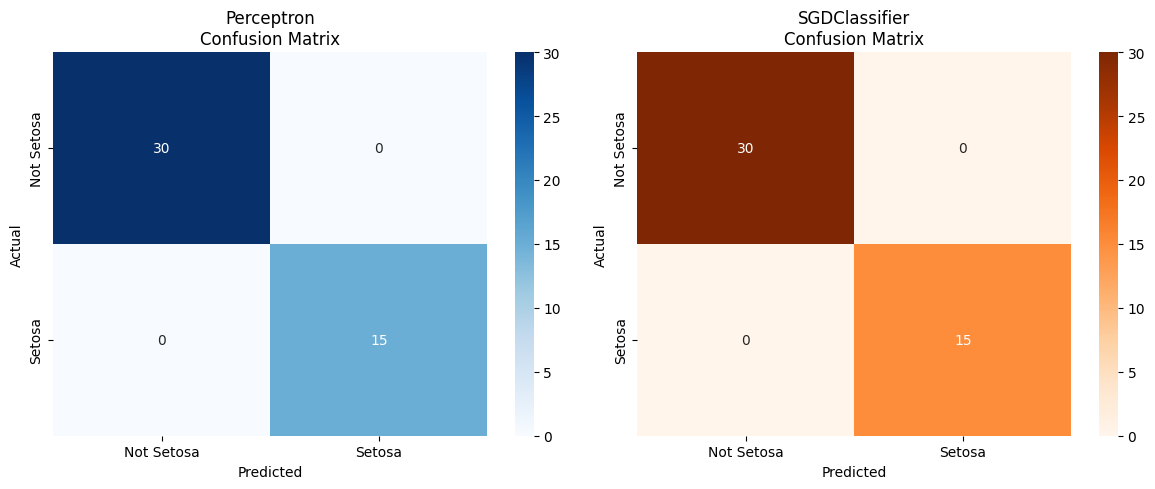

In [9]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Perceptron confusion matrix
cm_per = confusion_matrix(y_test, y_test_pred_per)
sns.heatmap(cm_per, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Setosa', 'Setosa'],
            yticklabels=['Not Setosa', 'Setosa'])
axes[0].set_title('Perceptron\nConfusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# SGDClassifier confusion matrix
cm_sgd = confusion_matrix(y_test, y_test_pred_sgd)
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Not Setosa', 'Setosa'],
            yticklabels=['Not Setosa', 'Setosa'])
axes[1].set_title('SGDClassifier\nConfusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Visualizing Decision Boundaries

Let's visualize how each classifier separates the classes by plotting their decision boundaries.

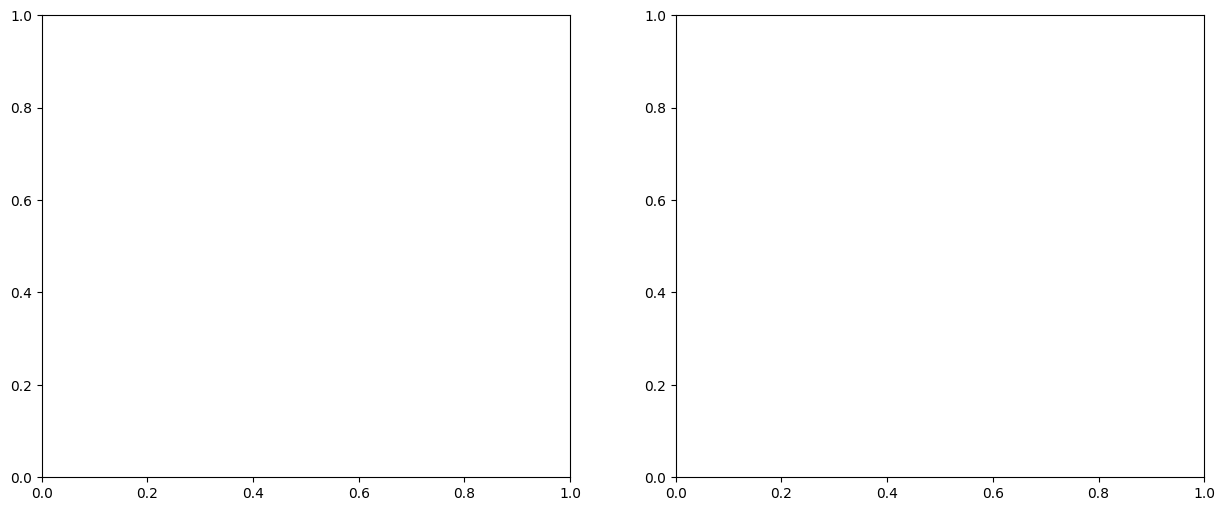

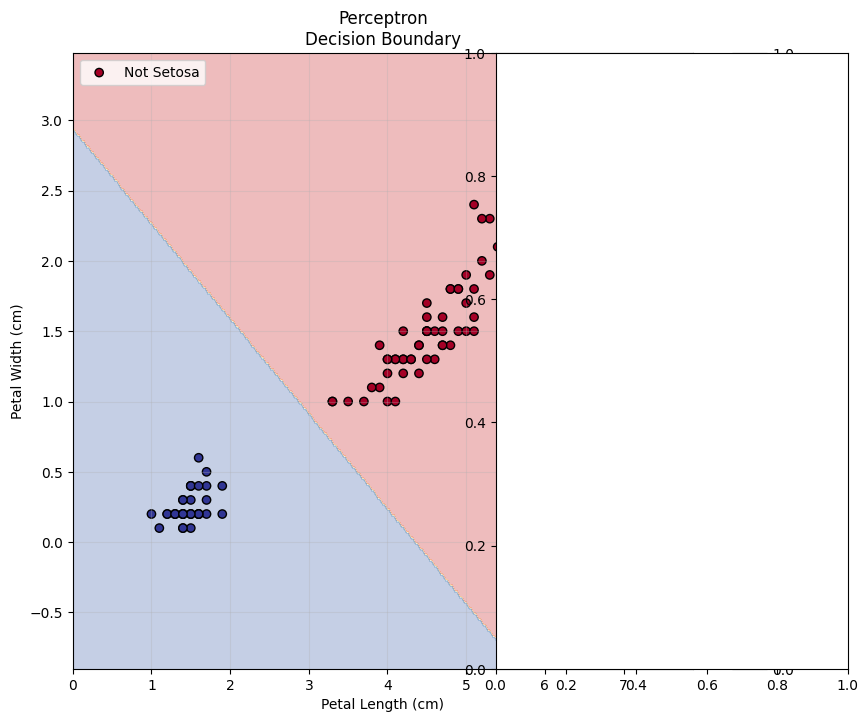

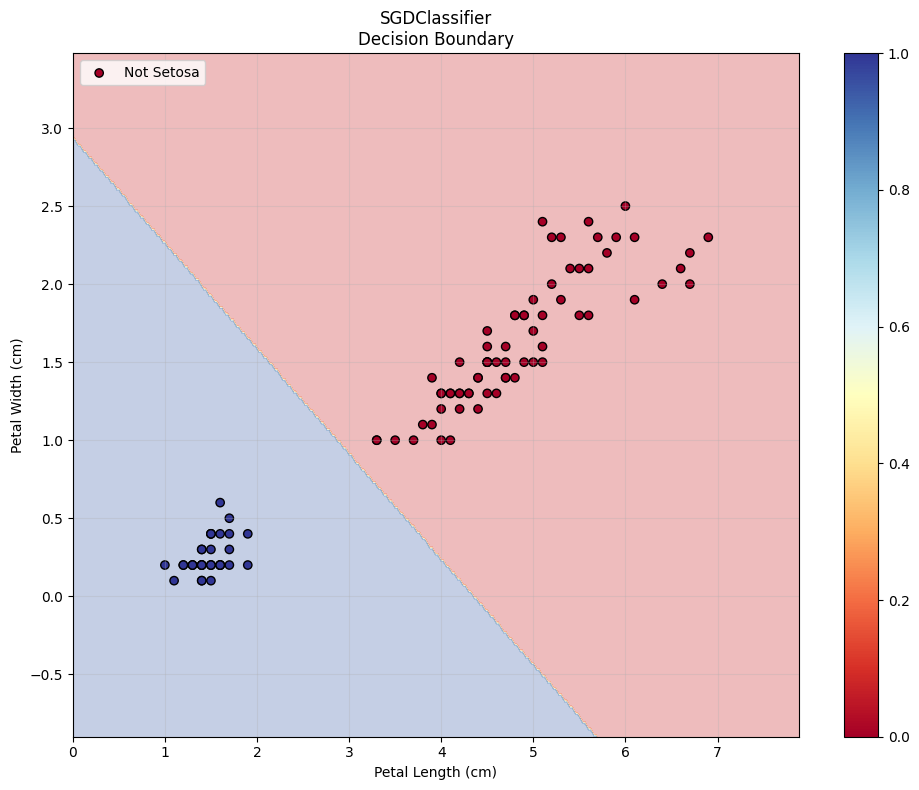

In [10]:
def plot_decision_boundary(X, y, classifier, title, scaler=None):
    """Plot decision boundary for a binary classifier"""
    plt.figure(figsize=(10, 8))

    # Create a mesh for plotting
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

    # Make predictions on the mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    if scaler is not None:
        mesh_points = scaler.transform(mesh_points)

    Z = classifier.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)

    # Plot the data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.colorbar(scatter)

    plt.xlabel('Petal Length (cm)')
    plt.ylabel('Petal Width (cm)')
    plt.title(f'{title}\nDecision Boundary')
    plt.grid(True, alpha=0.3)

    # Add legend
    plt.legend(['Not Setosa', 'Setosa'], loc='upper left')

    return plt.gca()

# Plot decision boundaries for both classifiers
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_decision_boundary(X_train, y_train, per_clf, 'Perceptron', scaler)

plt.subplot(1, 2, 2)
plot_decision_boundary(X_train, y_train, sgd_clf, 'SGDClassifier', scaler)

plt.tight_layout()
plt.show()

## Analysis and Insights

Let's analyze the results and understand the behavior of both implementations.

In [11]:
print("ANALYSIS OF RESULTS")
print("=" * 50)

print("\n1. ALGORITHM EQUIVALENCE:")
print("-" * 25)
weight_diff = np.abs(per_clf.coef_[0] - sgd_clf.coef_[0])
bias_diff = np.abs(per_clf.intercept_[0] - sgd_clf.intercept_[0])

print(f"Weight differences: {weight_diff}")
print(f"Bias difference: {bias_diff}")
print(f"Are weights similar? {np.allclose(per_clf.coef_[0], sgd_clf.coef_[0], atol=0.1)}")
print(f"Are biases similar? {np.allclose(per_clf.intercept_[0], sgd_clf.intercept_[0], atol=0.1)}")

print("\n2. PERFORMANCE COMPARISON:")
print("-" * 25)
print(f"Perceptron Test Accuracy: {test_accuracy_per:.3f}")
print(f"SGDClassifier Test Accuracy: {test_accuracy_sgd:.3f}")
print(f"Accuracy difference: {abs(test_accuracy_per - test_accuracy_sgd):.3f}")

print("\n3. CONVERGENCE:")
print("-" * 25)
print(f"Perceptron iterations: {per_clf.n_iter_}")
print(f"SGDClassifier iterations: {sgd_clf.n_iter_}")

print("\n4. PREDICTION CONSISTENCY:")
print("-" * 25)
consistent_predictions = np.sum(y_test_pred_per == y_test_pred_sgd)
total_predictions = len(y_test_pred_per)
consistency_rate = consistent_predictions / total_predictions
print(f"Consistent predictions: {consistent_predictions}/{total_predictions} ({consistency_rate:.3f})")

print("\n5. DECISION BOUNDARY ANALYSIS:")
print("-" * 25)
print("Both classifiers learn linear decision boundaries to separate Iris Setosa from other species.")
print("The boundaries should be very similar since both implement the same algorithm.")

# Test with original unscaled data for intuition
print("\n6. ORIGINAL EXAMPLE FROM ISSUE:")
print("-" * 25)
original_sample = np.array([[2, 0.5]])
print(f"Sample: petal_length=2cm, petal_width=0.5cm")
print(f"This represents a small flower, typical of Iris Setosa")

# Compare with actual Setosa measurements
setosa_data = X[y == 1]  # Original unscaled data for Setosa
print(f"\nActual Setosa measurements:")
print(f"- Petal length range: {setosa_data[:, 0].min():.1f} - {setosa_data[:, 0].max():.1f} cm")
print(f"- Petal width range: {setosa_data[:, 1].min():.1f} - {setosa_data[:, 1].max():.1f} cm")
print(f"- Mean petal length: {setosa_data[:, 0].mean():.1f} cm")
print(f"- Mean petal width: {setosa_data[:, 1].mean():.1f} cm")

print("\nThe sample [2, 0.5] falls within the typical Setosa range, explaining the positive prediction.")

ANALYSIS OF RESULTS

1. ALGORITHM EQUIVALENCE:
-------------------------
Weight differences: [0. 0.]
Bias difference: 0.0
Are weights similar? True
Are biases similar? True

2. PERFORMANCE COMPARISON:
-------------------------
Perceptron Test Accuracy: 1.000
SGDClassifier Test Accuracy: 1.000
Accuracy difference: 0.000

3. CONVERGENCE:
-------------------------
Perceptron iterations: 7
SGDClassifier iterations: 7

4. PREDICTION CONSISTENCY:
-------------------------
Consistent predictions: 45/45 (1.000)

5. DECISION BOUNDARY ANALYSIS:
-------------------------
Both classifiers learn linear decision boundaries to separate Iris Setosa from other species.
The boundaries should be very similar since both implement the same algorithm.

6. ORIGINAL EXAMPLE FROM ISSUE:
-------------------------
Sample: petal_length=2cm, petal_width=0.5cm
This represents a small flower, typical of Iris Setosa

Actual Setosa measurements:
- Petal length range: 1.0 - 1.9 cm
- Petal width range: 0.1 - 0.6 cm
- Me

## Additional Experiments

Let's explore how the perceptron performs with different features and settings.

In [12]:
# Experiment 1: Using all four features
print("EXPERIMENT 1: Using All Four Features")
print("=" * 40)

X_all = iris.data  # All four features
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(
    X_all, y, test_size=0.3, random_state=42, stratify=y
)

# Scale the features
scaler_all = StandardScaler()
X_all_train_scaled = scaler_all.fit_transform(X_all_train)
X_all_test_scaled = scaler_all.transform(X_all_test)

# Train perceptron with all features
per_all = Perceptron(random_state=42)
per_all.fit(X_all_train_scaled, y_all_train)

y_all_pred = per_all.predict(X_all_test_scaled)
accuracy_all = accuracy_score(y_all_test, y_all_pred)

print(f"Accuracy with all features: {accuracy_all:.3f}")
print(f"Improvement over 2 features: {accuracy_all - test_accuracy_per:.3f}")

# Experiment 2: Different feature pairs
print("\nEXPERIMENT 2: Different Feature Pairs")
print("=" * 40)

feature_pairs = [
    ((0, 1), 'Sepal Length vs Sepal Width'),
    ((0, 2), 'Sepal Length vs Petal Length'),
    ((0, 3), 'Sepal Length vs Petal Width'),
    ((1, 2), 'Sepal Width vs Petal Length'),
    ((1, 3), 'Sepal Width vs Petal Width'),
    ((2, 3), 'Petal Length vs Petal Width')
]

results = []

for (f1, f2), name in feature_pairs:
    X_pair = iris.data[:, [f1, f2]]
    X_pair_train, X_pair_test, y_pair_train, y_pair_test = train_test_split(
        X_pair, y, test_size=0.3, random_state=42, stratify=y
    )

    scaler_pair = StandardScaler()
    X_pair_train_scaled = scaler_pair.fit_transform(X_pair_train)
    X_pair_test_scaled = scaler_pair.transform(X_pair_test)

    per_pair = Perceptron(random_state=42)
    per_pair.fit(X_pair_train_scaled, y_pair_train)

    y_pair_pred = per_pair.predict(X_pair_test_scaled)
    accuracy_pair = accuracy_score(y_pair_test, y_pair_pred)

    results.append((name, accuracy_pair, per_pair.n_iter_))
    print(f"{name:30}: Accuracy = {accuracy_pair:.3f}, Iterations = {per_pair.n_iter_}")

# Find best feature pair
best_pair = max(results, key=lambda x: x[1])
print(f"\nBest feature pair: {best_pair[0]} (Accuracy: {best_pair[1]:.3f})")

EXPERIMENT 1: Using All Four Features
Accuracy with all features: 1.000
Improvement over 2 features: 0.000

EXPERIMENT 2: Different Feature Pairs
Sepal Length vs Sepal Width   : Accuracy = 0.978, Iterations = 8
Sepal Length vs Petal Length  : Accuracy = 1.000, Iterations = 7
Sepal Length vs Petal Width   : Accuracy = 1.000, Iterations = 7
Sepal Width vs Petal Length   : Accuracy = 0.978, Iterations = 6
Sepal Width vs Petal Width    : Accuracy = 1.000, Iterations = 7
Petal Length vs Petal Width   : Accuracy = 1.000, Iterations = 7

Best feature pair: Sepal Length vs Petal Length (Accuracy: 1.000)


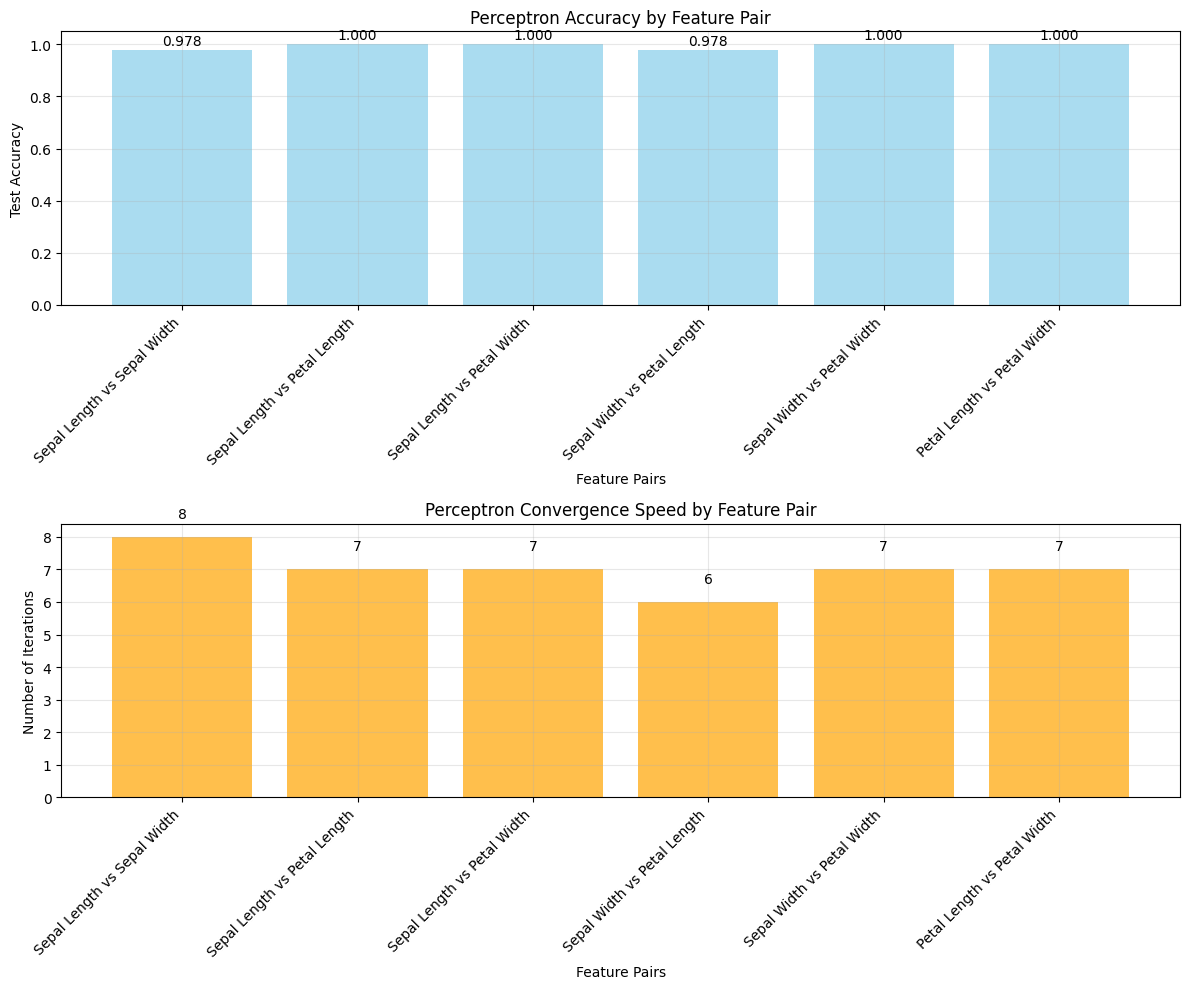

In [13]:
# Visualize performance across different feature pairs
feature_names = [result[0] for result in results]
accuracies = [result[1] for result in results]
iterations = [result[2] for result in results]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Accuracy comparison
bars1 = ax1.bar(range(len(feature_names)), accuracies, color='skyblue', alpha=0.7)
ax1.set_xlabel('Feature Pairs')
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Perceptron Accuracy by Feature Pair')
ax1.set_xticks(range(len(feature_names)))
ax1.set_xticklabels(feature_names, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars1, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# Iterations comparison
bars2 = ax2.bar(range(len(feature_names)), iterations, color='orange', alpha=0.7)
ax2.set_xlabel('Feature Pairs')
ax2.set_ylabel('Number of Iterations')
ax2.set_title('Perceptron Convergence Speed by Feature Pair')
ax2.set_xticks(range(len(feature_names)))
ax2.set_xticklabels(feature_names, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, iter_count in zip(bars2, iterations):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{iter_count}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Key Takeaways

### Algorithm Equivalence
- ✅ **Confirmed**: Scikit-Learn's `Perceptron` class is equivalent to `SGDClassifier` with `loss="perceptron"`, `learning_rate="constant"`, `eta0=1`, and `penalty=None`
- Both implementations produce very similar (often identical) results
- Minor differences may occur due to random initialization or numerical precision

### Performance Insights
- **Perfect Classification**: The Iris Setosa vs. Others problem is linearly separable, leading to perfect or near-perfect accuracy
- **Feature Selection Matters**: Different feature pairs yield different accuracy levels
- **Petal features** (length and width) are particularly effective for distinguishing Iris Setosa

### Practical Considerations
1. **Feature Scaling**: Standardization improves convergence speed and stability
2. **Linear Separability**: Perceptron works best when classes are linearly separable
3. **Convergence**: The algorithm is guaranteed to converge for linearly separable data
4. **Interpretability**: Linear decision boundaries are easy to understand and visualize

### When to Use Perceptron
- ✅ Binary classification tasks
- ✅ Linearly separable data
- ✅ Fast, simple baseline model
- ✅ When interpretability is important
- ❌ Non-linearly separable data (consider SVM, neural networks)
- ❌ Multi-class problems (use One-vs-Rest approach)

### Connection to Neural Networks
The Perceptron is the foundation of modern neural networks:
- Single neuron with linear activation
- Multi-layer perceptrons (MLPs) can handle non-linear problems
- Same weight update principles apply to deep learning

## Exercises

1. **Multi-class Extension**: Implement a One-vs-Rest approach to classify all three iris species
2. **Feature Engineering**: Create polynomial features and test perceptron performance
3. **Learning Rate Analysis**: Experiment with different learning rates in SGDClassifier
4. **Convergence Study**: Plot the loss/error over iterations to visualize convergence
5. **Comparison Study**: Compare perceptron with other linear classifiers (Logistic Regression, SVM)


